In [5]:
%matplotlib inline

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', 'analysis'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', 'session'))

import numpy as np
from imports import *
from matplotlib.patches import ConnectionPatch
from scipy.stats import pearsonr
from target import build_tgt_matrix
np.set_printoptions(suppress=True)

In [6]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Tone-modulated units exhibit macro-structure relative to target On/Off-set

In [29]:
def get_spike_counts(spk_times, pulse_times, hw=0.25, bin_count=51):
    collected = []
    for t_pulse in pulse_times:
        selected = spk_times[(spk_times > t_pulse - hw) & (spk_times < t_pulse + hw)]
        collected += [x for x in selected - t_pulse]
    collected = np.array(collected)

    bins = np.linspace(-hw, hw, bin_count)
    counts, _ = np.histogram(collected, bins=bins)
    counts = (counts / len(pulse_times))# * 1/((2. * hw)/float(bin_count - 1))
    
    return bins, counts

In [30]:
source = '/home/sobolev/nevermind/Andrey/data'
area = 'A1'
example_units = {
    '009266_hippoSIT_2023-04-17_17-04-17': ['1-2', '1-4', '1-5', '1-9', '1-10', '1-11', '1-13', '1-14', '1-15', '2-2'],
    '009266_hippoSIT_2023-04-18_10-10-37': ['1-12', '1-13', '1-3', '1-8', '1-9', '2-13', '2-14', '2-7'],
    '009266_hippoSIT_2023-04-18_17-03-10': ['1-2', '1-6', '1-7', '1-18', '2-6', '2-3', '2-11'],
    '009266_hippoSIT_2023-04-19_10-33-51': ['1-4', '1-10', '1-11', '1-13', '1-16', '1-17', '1-19', '1-20']
}

unit_count = np.array([len(vals) for vals in example_units.values()]).sum()
unit_count

33

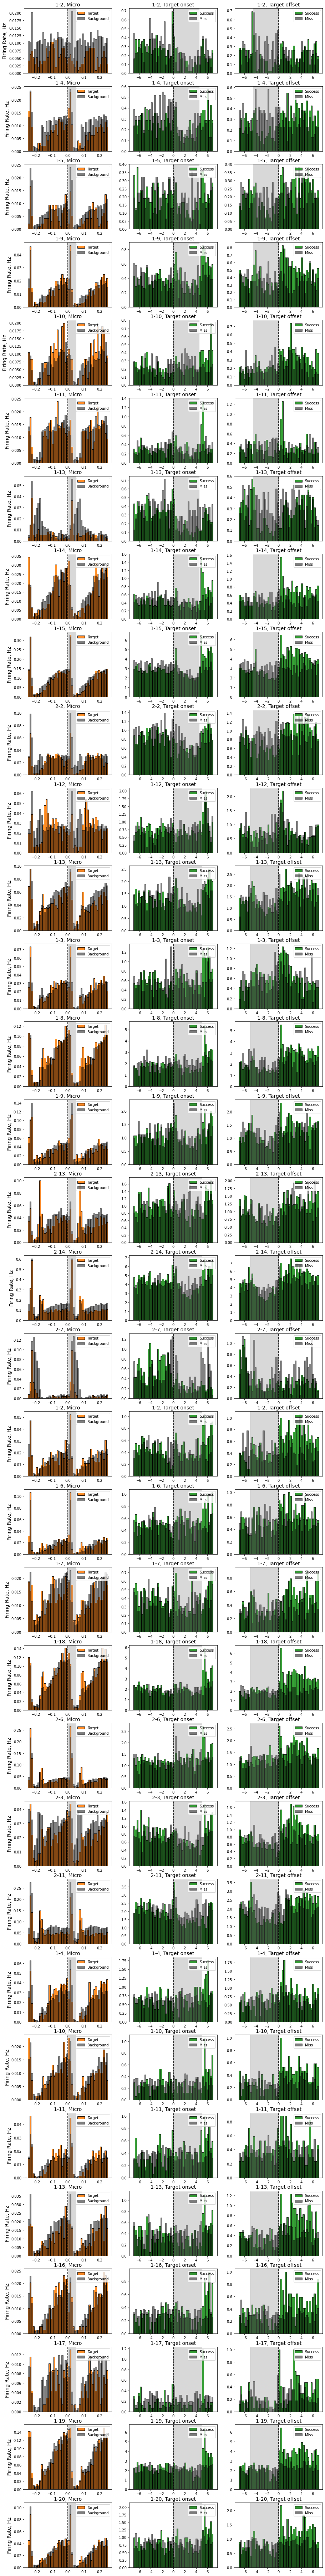

In [25]:
rows = int(unit_count)
fig = plt.figure(figsize=(15, 4*rows))
count = 0

for i, (session, unit_ids) in enumerate(example_units.items()): # = '009266_hippoSIT_2023-04-17_17-04-17', ['1-2', '1-4']
    animal    = session.split('_')[0]
    aeps_file = os.path.join(source, animal, session, 'AEPs.h5')
    h5_file   = os.path.join(source, animal, session, session + '.h5')

    # load configuration and timeline
    with h5py.File(h5_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])  # time, X, Y, speed, etc.
        trials = np.array(f['processed']['trial_idxs'])  # t_start_idx, t_end_idx, x_tgt, y_tgt, r_tgt, result
        cfg = json.loads(f['processed'].attrs['parameters'])
    tgt_dur = cfg['experiment']['target_duration']

    # load AEP events
    with h5py.File(aeps_file, 'r') as f:
        aeps = np.array(f[area]['aeps'])
        aeps_events = np.array(f['aeps_events'])

    # read single units
    spike_times = {}
    h5_file = os.path.join(source, animal, session, session + '.h5')
    with h5py.File(h5_file, 'r') as f:
        for unit_id in unit_ids:
            spike_times[unit_id] = np.array(f['units'][unit_id][H5NAMES.spike_times['name']])

    # timeline indices reward onset (silence onset, 20 + 0-5secs)
    idxs_reward = trials[trials[:, 5] == 1][:, 1].astype(np.int32)

    # timeline indices noise onset (10 secs)
    idxs_noise  = np.where(tl[:, 6] == -1)[0]
    idxs_to_idx = np.where(np.diff(idxs_noise) > 5)[0] + 1
    idxs_nos_start = np.concatenate([[idxs_noise[0]], idxs_noise[:-1][idxs_to_idx]])

    # build target matrix
    tgt_dur = cfg['experiment']['target_duration']
    tgt_matrix = build_tgt_matrix(tl, aeps_events, cfg['experiment']['target_duration'])

    # indices of success / miss to target matrix
    idxs_succ = np.where(tgt_matrix[:, 4] == 1)[0]
    idxs_miss = np.where(tgt_matrix[:, 4] == 0)[0]

    for unit_id in unit_ids:
        # micro-structure
        ax = fig.add_subplot(rows, 3, count+1)
        bins, s_counts_tgt = get_spike_counts(spike_times[unit_id], aeps_events[aeps_events[:, 1] == 2][:, 0], hw=0.25, bin_count=51)
        bins, s_counts_bgr = get_spike_counts(spike_times[unit_id], aeps_events[aeps_events[:, 1] == 1][:, 0], hw=0.25, bin_count=51)
        ax.hist(bins[:-1], bins=bins, weights=s_counts_tgt, edgecolor='black', color='tab:orange', alpha=0.9, label='Target')
        ax.hist(bins[:-1], bins=bins, weights=s_counts_bgr, edgecolor='black', color='black', alpha=0.5, label='Background')
        ax.axvline(0, color='black', ls='--')
        ax.set_title("%s, Micro" % unit_id, fontsize=14)
        ax.axvspan(0, 0.05, alpha=0.3, color='gray')
        ax.legend(loc='upper right', prop={'size': 10})
        ax.set_ylabel("Firing Rate, Hz", fontsize=14)

        # target onset
        ax = fig.add_subplot(rows, 3, count+2)
        bins, s_counts_m = get_spike_counts(spike_times[unit_id], tl[tgt_matrix[idxs_miss][:, 0]][:, 0], hw=7, bin_count=51)
        bins, s_counts_s = get_spike_counts(spike_times[unit_id], tl[tgt_matrix[idxs_succ][:, 0]][:, 0], hw=7, bin_count=51)
        ax.hist(bins[:-1], bins=bins, weights=s_counts_s, edgecolor='black', color='green', alpha=0.8, label='Success')
        ax.hist(bins[:-1], bins=bins, weights=s_counts_m, edgecolor='black', color='black', alpha=0.5, label='Miss')
        ax.axvline(0, color='black', ls='--')
        ax.set_title("%s, Target onset" % unit_id, fontsize=14)
        ax.axvspan(0, tgt_dur, alpha=0.3, color='gray')
        ax.legend(loc='upper right', prop={'size': 10})

        # target offset
        ax = fig.add_subplot(rows, 3, count+3)
        bins, s_counts_m = get_spike_counts(spike_times[unit_id], tl[tgt_matrix[idxs_miss][:, 1]][:, 0], hw=7, bin_count=51)
        bins, s_counts_s = get_spike_counts(spike_times[unit_id], tl[tgt_matrix[idxs_succ][:, 1]][:, 0], hw=7, bin_count=51)
        ax.hist(bins[:-1], bins=bins, weights=s_counts_s, edgecolor='black', color='green', alpha=0.8, label='Success')
        ax.hist(bins[:-1], bins=bins, weights=s_counts_m, edgecolor='black', color='black', alpha=0.5, label='Miss')
        ax.axvline(0, color='black', ls='--')
        ax.set_title("%s, Target offset" % unit_id, fontsize=14)
        ax.axvspan(-tgt_dur, 0, alpha=0.3, color='gray')
        ax.legend(loc='upper right', prop={'size': 10})
        
        count += 3

### Figure notes:

    Macro-response structure of the selected A1 units relative to the entrance / exit to the target. 
    Each row represents one neuron.
    1st column: micro-structure of the neuron (PSTH) relative to target / backgound (same as in p.2.1).
    2nd column: neuron response relative to target onset.
    3rd column: neuron response relative to target offset.
    Green / gray separates sucessful / missed entrances to the target.
    Gray shaded areas: pulse duration (1st column), max target duration (2nd and 3rd columns).
    Missed entrances to the trget might last shorter than target duration.
    Note suppressed responses of many neurons when in target.
    Note many reward-tuned A1 neurons.

## 3.2. Control: modulation by noise / reward

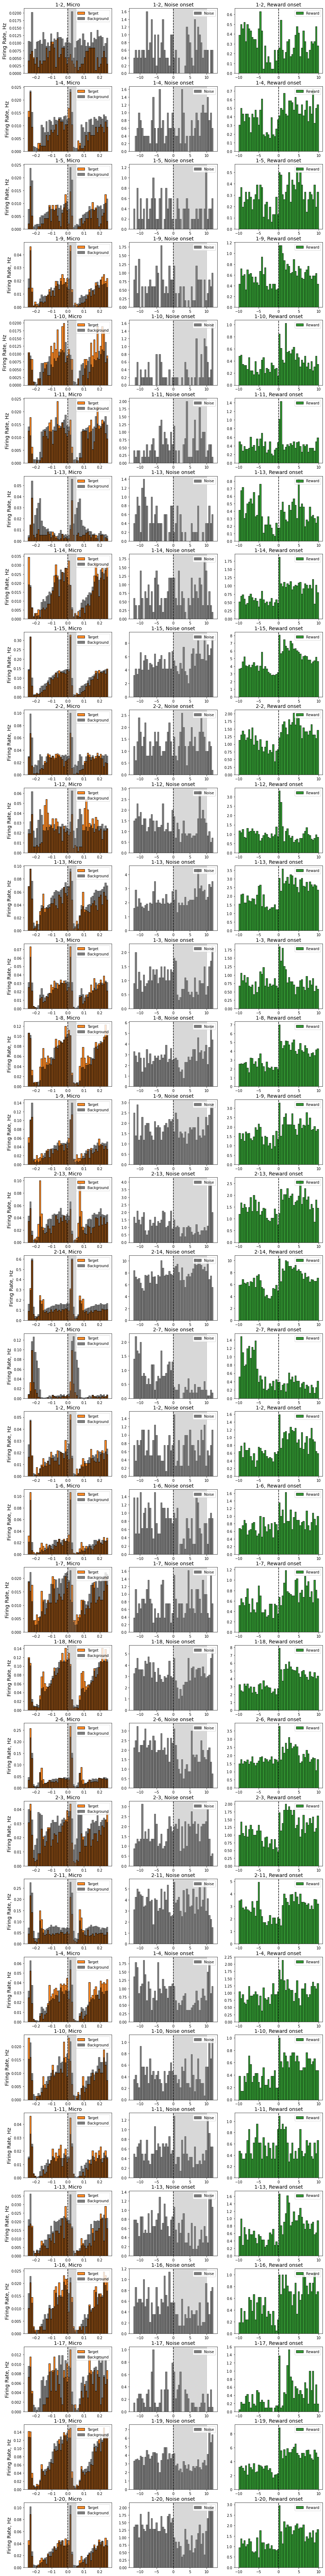

In [31]:
rows = int(unit_count)
fig = plt.figure(figsize=(15, 4*rows))
count = 0

for i, (session, unit_ids) in enumerate(example_units.items()): # = '009266_hippoSIT_2023-04-17_17-04-17', ['1-2', '1-4']
    animal    = session.split('_')[0]
    aeps_file = os.path.join(source, animal, session, 'AEPs.h5')
    h5_file   = os.path.join(source, animal, session, session + '.h5')

    # load configuration and timeline
    with h5py.File(h5_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])  # time, X, Y, speed, etc.
        trials = np.array(f['processed']['trial_idxs'])  # t_start_idx, t_end_idx, x_tgt, y_tgt, r_tgt, result
        cfg = json.loads(f['processed'].attrs['parameters'])
    noise_dur = cfg['experiment']['punishment_duration']

    # load AEP events
    with h5py.File(aeps_file, 'r') as f:
        aeps = np.array(f[area]['aeps'])
        aeps_events = np.array(f['aeps_events'])

    # read single units
    spike_times = {}
    h5_file = os.path.join(source, animal, session, session + '.h5')
    with h5py.File(h5_file, 'r') as f:
        for unit_id in unit_ids:
            spike_times[unit_id] = np.array(f['units'][unit_id][H5NAMES.spike_times['name']])

    # timeline indices reward onset (silence onset, 20 + 0-5secs)
    idxs_reward = trials[trials[:, 5] == 1][:, 1].astype(np.int32)

    # timeline indices noise onset (10 secs)
    idxs_noise  = np.where(tl[:, 6] == -1)[0]
    idxs_to_idx = np.where(np.diff(idxs_noise) > 5)[0] + 1
    idxs_nos_start = np.concatenate([[idxs_noise[0]], idxs_noise[:-1][idxs_to_idx]])

    # build target matrix
    tgt_dur = cfg['experiment']['target_duration']
    tgt_matrix = build_tgt_matrix(tl, aeps_events, cfg['experiment']['target_duration'])

    # indices of success / miss to target matrix
    idxs_succ = np.where(tgt_matrix[:, 4] == 1)[0]
    idxs_miss = np.where(tgt_matrix[:, 4] == 0)[0]

    for unit_id in unit_ids:
        # micro-structure
        ax = fig.add_subplot(rows, 3, count+1)
        bins, s_counts_tgt = get_spike_counts(spike_times[unit_id], aeps_events[aeps_events[:, 1] == 2][:, 0], hw=0.25, bin_count=51)
        bins, s_counts_bgr = get_spike_counts(spike_times[unit_id], aeps_events[aeps_events[:, 1] == 1][:, 0], hw=0.25, bin_count=51)
        ax.hist(bins[:-1], bins=bins, weights=s_counts_tgt, edgecolor='black', color='tab:orange', alpha=0.9, label='Target')
        ax.hist(bins[:-1], bins=bins, weights=s_counts_bgr, edgecolor='black', color='black', alpha=0.5, label='Background')
        ax.axvline(0, color='black', ls='--')
        ax.set_title("%s, Micro" % unit_id, fontsize=14)
        ax.axvspan(0, 0.05, alpha=0.3, color='gray')
        ax.legend(loc='upper right', prop={'size': 10})
        ax.set_ylabel("Firing Rate, Hz", fontsize=14)

        # noise
        ax = fig.add_subplot(rows, 3, count+2)
        bins, s_counts_s = get_spike_counts(spike_times[unit_id], tl[idxs_nos_start][:, 0], hw=12, bin_count=51)
        ax.hist(bins[:-1], bins=bins, weights=s_counts_s, edgecolor='black', color='black', alpha=0.5, label='Noise')
        ax.axvline(0, color='black', ls='--')
        ax.set_title("%s, Noise onset" % unit_id, fontsize=14)
        ax.axvspan(0, noise_dur, alpha=0.3, color='gray')
        ax.legend(loc='upper right', prop={'size': 10})

        # reward
        ax = fig.add_subplot(rows, 3, count+3)
        bins, s_counts_s = get_spike_counts(spike_times[unit_id], tl[idxs_reward][:, 0], hw=10, bin_count=51)
        ax.hist(bins[:-1], bins=bins, weights=s_counts_s, edgecolor='black', color='green', alpha=0.8, label='Reward')
        ax.axvline(0, color='black', ls='--')
        ax.set_title("%s, Reward onset" % unit_id, fontsize=14)
        ax.legend(loc='upper right', prop={'size': 10})
       
        count += 3

### Figure notes:

    Macro-response structure of the selected A1 units relative to noise / reward (silence) onset.
    Each row represents one neuron.
    1st column: micro-structure of the neuron (PSTH) relative to target / backgound (same as in p.2.1).
    2nd column: neuron response relative to noise onset.
    3rd column: neuron response relative to reward (silence) onset.
    Gray shaded areas: pulse duration (1st column), noise duration (2nd column).
    Note many neurons selective for the reward onset.
    Note many neurons have higher firing rate in silence (or lower firing when background)
    Note some neurons (2-7) have increased firing rate when in background.

## 3.3. Phasic modulation of neuronal tuning is (not) due to behavioral relevance of the target

In [2]:
# Some more controls - to be implemented 

## 3.4. Spatial / azimutal tuning of single neurons

In [3]:
# Some more controls - to be implemented 